In [1]:
try:
  %tensorflow_version 1.x
except Exception:
  pass
import tensorflow as tf
assert tf.__version__.startswith('1')

tf.enable_eager_execution()

import os
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [3]:
!unzip '/content/train.zip'

Archive:  /content/train.zip
   creating: data/bajra/
  inflating: data/bajra/1511340347-4701.jpg  
  inflating: data/bajra/1583912022_Jowar_big_2.jpg  
  inflating: data/bajra/2aa98bcad23f92a695505239de73d941.jpg  
  inflating: data/bajra/49ba5b2c0360ba0658fdacd4e94b6ec4.jpg  
  inflating: data/bajra/5000-hybrid-pioneer-86m11-bajra-seeds-pearl-millet-seeds-1-5kg-original-imaft7xedxesp9aa.jpeg  
  inflating: data/bajra/5000-trimurti-tmbh-2652-bajra-seeds-pearl-millet-seeds-1-5kg-original-imaft8gvykbfke5n.jpeg  
  inflating: data/bajra/531f61_42baae386ec44ea7bdda77804c5feefemv2_d_2992_2000_s_2.jpg  
  inflating: data/bajra/853476-bajra-072919.jpg  
  inflating: data/bajra/8b9f17943f53dab4aa225b9235552ab2.jpg  
  inflating: data/bajra/bajra.jpg    
  inflating: data/bajra/bajra0.jpg   
  inflating: data/bajra/bajra21.jpg  
  inflating: data/bajra/Bajra-Cultivation.jpg  
  inflating: data/bajra/bajra-millet-DFYWMR.jpg  
  inflating: data/bajra/bajra-millet-pennisetum-glaucum-field-rajguru

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/content/data',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    '/content/data',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 794 images belonging to 10 classes.
Found 190 images belonging to 10 classes.


In [5]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 10))

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('crop_labels.txt', 'w') as f:
  f.write(labels)

{'bajra': 0, 'corn': 1, 'cotton': 2, 'jute': 3, 'rice': 4, 'sugarcane': 5, 'sunflower': 6, 'tea': 7, 'tobacco': 8, 'wheat': 9}


In [7]:
!cat crop_labels.txt

bajra
corn
cotton
jute
rice
sugarcane
sunflower
tea
tobacco
wheat

In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=10, activation='softmax')
])

In [16]:
for layers in model.layers[:-36]:
  layers.trainable=False

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 2,626,986
Trainable params: 369,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 2,626,986
Trainable params: 2,231,594
Non-trainable params: 395,392
_________________________________________________________________


In [25]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 60


In [ ]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

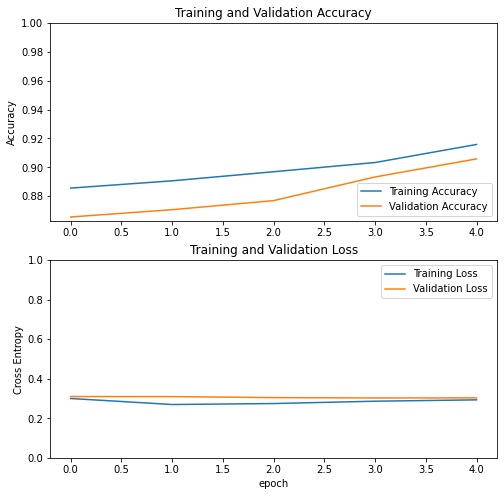

In [36]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
saved_keras_model = 'model.h5'
model.save(saved_keras_model)

converter = tf.lite.TFLiteConverter.from_keras_model_file(saved_keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

In [39]:
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files('/content/data' + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

saved_keras_model = 'model.h5'
model.save(saved_keras_model)

converter = tf.lite.TFLiteConverter.from_keras_model_file(saved_keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)